# Exploratory Data Analysis of Labelled Dataset

This notebook analyzes the `LabelledCommits*.csv` files that contain aggregated commit information with two sets of labels. The first label, `Predicted Label`, was generated by an LLM along with the `Reasoning` column to record its reasoning for that label. The second label `Actual Label` was set after I manually reviewed the predictions and recorded the correct value in the `Predicted Label` value.

Having a predicted value was helpful for stratifying the sampled data by repository and by predicted class. See `TrainingAggregation.ipynb` for details on that process, but at a high level I made a proportional sampling of the various repositories in the full population of LLM predictions. I wanted to make sure each repository was proportionally represented, with minority repositories getting a bit more representation than they otherwise should have to ensure we had enough data for train / test split. I also ensured we had an even distribution of true / false predictions at the per-repository level and ensured that the overall trends and characteristics of the sample matched those of the full population. All of this is detailed in `TrainingAggregation.ipynb`.

This notebook's job is to perform final EDA and cleanup of the manually labelled sample, look for class imbalances, and look for final correlation values. Due to choosing to defer some numeric outlier handling to the model training process as part of the transformation pipeline (where I will clamp values as needed at high / low quantiles), some of these correlations may be different from than they would be if outliers were appropriately transformed - most likely closer to zero than they normally would be.

This notebook relies on data files that exist in its git repository located at [https://github.com/IntegerMan/GitStractorCommitClassification](https://github.com/IntegerMan/GitStractorCommitClassification) The notebook also requires the base Anaconda dependencies plus SciKit-Plot for a short analysis of the predicted vs actual labels present in my training data.

Note that the data going in to my model training process will look something like the data in this notebook, but will not contain columns like the predicted label (preferring the actual label instead), and will drop potential bias columns like date / author info, and will likely remove low correlation columns or columns highly correlated with other columns. That process will be noted in the model training and evaluation notebooks.

## Imports & Shared Functions

The following functions are used by multiple cells in the Notebook:

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [2]:
# Plotly and plotly common settings and aliases
import plotly.express as px

# Specify defaults for Plotly settings
px.defaults.color_continuous_scale = px.colors.sequential.Agsunset
px.defaults.color_discrete_sequence = px.colors.qualitative.Prism
#px.defaults.template = 'plotly_dark'
px.defaults.template = 'plotly_white'

# Set up common aliases for Plotly
common_labels={'DayOfWeek': 'Day of Week'}
common_hover_info = ['Message', 'Repository', 'Modified Files', 'Added Files', 'Deleted Files', 'Added Lines', 'Deleted Lines', 'Net Lines', 'Is Bug Fix']

In [3]:
# Pre-correlation analysis transformation function for our merged data later
def build_df_corr(df):
    # Drop text columns that would cause errors on .corr()
    df_corr = df.drop(columns=['Sha', 'Message'])

    # Replace df_corr's month, day of week, and time of day with numeric values since they can be viewed as sequences
    df_corr['Month'] = df_corr['Month'].cat.codes
    df_corr['DayOfWeek'] = df_corr['DayOfWeek'].cat.codes
    df_corr['TimeOfDay'] = df_corr['TimeOfDay'].cat.codes

    # Let's one-hot encode the Repository column just so we can see differences in our sample data from repo to repo
    df_corr = pd.get_dummies(df_corr, columns=['Repository'])
    
    return df_corr

In [4]:
# Correlation analysis fnction. 
def show_corr(df):

    corr = df.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # Create a masked correlation matrix
    masked_corr = corr.mask(mask)

    # Build formatted text to show on our annotations
    text = masked_corr.map(lambda x: '' if np.isnan(x) or x == 0 else '{0:.2f}'.format(x))

    heat = go.Heatmap(z=masked_corr,
                    x=df.columns,
                    y=df.columns,
                    text=text,
                    texttemplate='%{text}',
                    xgap=1, ygap=1,
                    zmin=-1,
                    zmax=1,
                    colorbar_thickness=20,
                    colorbar_ticklen=3,
                    )

    layout = go.Layout(title_text='Correlation Matrix', title_x=0.5, 
                    height=800,
                    xaxis_showgrid=False,
                    yaxis_showgrid=False,
                    yaxis_autorange='reversed')
    
    fig=go.Figure(data=[heat], layout=layout)        
    fig.show() 

In [5]:
def show_merged_corr(df):
    df_corr = build_df_corr(df)
    show_corr(df_corr)

## Loading Labelled Data

In [6]:
df = pd.read_csv('data/LabelledCommits.csv')
df.head()

,Predicted Label,Actual Label,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,...,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,Is Weekend,Message Length,Word Count,Unnamed: 33
0,False,False,Merge pull request #2836 from AbhitejJohn/fixtypo,The commit message does not explicitly mention...,further context needed,b611a4a5401468b7734d2b009e23889bae3818d3,dotnetinteractive,d8b80c3010319df99c115b8b0eaf622e9ced603d,340acfc3d824d5a6c4238cc20e6caf4552a67b1c,True,...,False,Tuesday,March,1,2023,18,Afternoon,False,49,6.0
1,False,False,notebook changes,The term 'changes' is too vague and doesn't sp...,d5a26683e4f1d2ab4d6de82941efee5bb427ebd3,dotnetinteractive,85d038234705fe1936a380b61ee2aaad66930a03,NaN,False,10,...,Thursday,February,1,2021,19,Evening,False,16,2,NaN
2,False,False,Merge pull request #553 from cartermp/fsharp-s...,Pull request reference does not indicate a bug...,a51e8526d30521cbdc29c484ffd080fb0c9656b2,dotnetinteractive,342b0de01d4dfcfc97f0f71bf4e711bdd0be6edc,aa0e789b01c6fb683804eca8e041a378cf075694,True,10,...,Friday,October,4,2019,5,Night,False,59,6,NaN
3,False,False,Update dependencies from https://github.com/do...,The description suggests updating software com...,2f30b1841bb7a6555196b94c4c7d829c1ad362e1,dotnetinteractive,d3e65742fe6ae8b4646476465b7532d99a6e041f,NaN,False,23,...,Monday,December,4,2020,8,Morning,False,74,6,NaN
4,False,False,update dotnet sdk to 3.1.200,Updating SDK versions is typically for improvi...,43fc343f58c56436c1331f2d6695540895132286,dotnetinteractive,82b05923b0c02253bc1787a451925547c4cf0b48,NaN,False,8,...,Monday,March,1,2020,14,Afternoon,False,28,5,NaN


In [7]:
df.columns

Index(['Predicted Label', 'Actual Label', 'Message', 'Reasoning', 'Sha',
       'Source', 'ParentSha', 'Parent2Sha', 'IsMerge', 'AuthorId',
       'AuthorDateUtc', 'CommitterId', 'CommitterDateUtc', 'Work Items',
       'Total Files', 'Modified Files', 'Added Files', 'Deleted Files',
       'Total Lines', 'Net Lines', 'Added Lines', 'Deleted Lines',
       'Has Added Files', 'Has Deleted Files', 'DayOfWeek', 'Month', 'Quarter',
       'Year', 'Hour', 'TimeOfDay', 'Is Weekend', 'Message Length',
       'Word Count', 'Unnamed: 33'],
      dtype='object')

Weird. We shouldn't have an Unnamed: 33 column. Let's look at column info.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Predicted Label    500 non-null    bool   
 1   Actual Label       500 non-null    bool   
 2   Message            500 non-null    object 
 3   Reasoning          500 non-null    object 
 4   Sha                500 non-null    object 
 5   Source             500 non-null    object 
 6   ParentSha          500 non-null    object 
 7   Parent2Sha         35 non-null     object 
 8   IsMerge            493 non-null    object 
 9   AuthorId           500 non-null    object 
 10  AuthorDateUtc      500 non-null    object 
 11  CommitterId        500 non-null    object 
 12  CommitterDateUtc   500 non-null    object 
 13  Work Items         500 non-null    object 
 14  Total Files        500 non-null    int64  
 15  Modified Files     500 non-null    int64  
 16  Added Files        500 non

Interesting. Looks like we have data in 10 rows for this. I also note null values in `IsMerge` which shouldn't be possible.

Null values are normal for Parent2Sha for all non-merge commits, so that's expected.

In [9]:
# Looks like we have some missing values in IsMerge. Interesting. I wasn't aware this was possible. Let's see what they are.
df[df['IsMerge'].isnull()]

,Predicted Label,Actual Label,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,...,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,Is Weekend,Message Length,Word Count,Unnamed: 33
20,False,False,improving the lifespan of the universe,The subject matter is unrelated to software or...,it appears metaphorical or non-technical.,8197088fd4b4afccfaee58a8020675b62a399013,dotnetinteractive,ebc7b5f027331ba1b0483a1da481c5f43a92a7d0,NaN,False,...,False,Tuesday,August,3,2021,17,Afternoon,False,38,6.0
32,False,False,Allow the user to specify the port,Not related to solving an existing problem or ...,rather it's about adding a new feature for cu...,1d2477e64352738c97318ec9fcae77e328fe9811,dotnetinteractive,43c287aab5eed1065d48eb0ffec73c33237d47be,NaN,False,...,False,Thursday,May,2,2019,17,Afternoon,False,34,7.0
95,False,False,update file,Too vague,does it indicate updating for fixing or gener...,4b81ebc19d4972f808a96856b370a0e43a1d2b84,dotnetinteractive,564f833ecfbf602c8900137c9f8f471a5fe58efa,NaN,False,...,False,Saturday,January,1,2021,9,Morning,True,11,2.0
116,False,False,update HttpRequestKernel to use new parser,support variable expressions in request body ...,The commit is improving functionality by addin...,a5548386d51df1464db44a7a5a17886d165a1f70,dotnetinteractive,8aa65342a3a32e92e28501bbc7f1b578d3dd7a7a,NaN,False,...,False,Thursday,August,3,2023,10,Morning,False,96,13.0
142,False,False,only for him,The commit message 'only for him' does not pro...,it suggests the change is personal or scoped ...,c9b91b42372d3b80c2ac6d54490db7b906291e90,dotnetinteractive,3a0560bb55816c700ea1c67d92c1a420b607fbc9,NaN,False,...,False,Monday,March,1,2020,19,Evening,False,12,3.0
182,True,False,Update CredScanSuppressions.json,CredScan suppression files are typically used ...,updating them could imply fixing issues these...,397e8a0c03cdd45535bae8a26dede3bb38145f7d,dotnetinteractive,5a08412e8ceca2e1b4948dbaec6778e800d357a3,NaN,False,...,False,Friday,November,4,2022,12,Morning,False,32,2.0
408,False,False,Updated branch version (#5400),The commit message is too vague,there's insufficient context to determine if ...,4960f9de83351b25874e58d1ca504c9a32aa1112,mlnet,5929292f4c45a330b2b2541bd59ff2138424a6ee,NaN,False,...,False,Tuesday,September,3,2020,16,Afternoon,False,30,4.0


In [10]:
# Find values non-null for Unnamed: 33
df[df['Unnamed: 33'].notnull()]

,Predicted Label,Actual Label,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,...,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,Is Weekend,Message Length,Word Count,Unnamed: 33
0,False,False,Merge pull request #2836 from AbhitejJohn/fixtypo,The commit message does not explicitly mention...,further context needed,b611a4a5401468b7734d2b009e23889bae3818d3,dotnetinteractive,d8b80c3010319df99c115b8b0eaf622e9ced603d,340acfc3d824d5a6c4238cc20e6caf4552a67b1c,True,...,False,Tuesday,March,1,2023,18,Afternoon,False,49,6.0
20,False,False,improving the lifespan of the universe,The subject matter is unrelated to software or...,it appears metaphorical or non-technical.,8197088fd4b4afccfaee58a8020675b62a399013,dotnetinteractive,ebc7b5f027331ba1b0483a1da481c5f43a92a7d0,NaN,False,...,False,Tuesday,August,3,2021,17,Afternoon,False,38,6.0
32,False,False,Allow the user to specify the port,Not related to solving an existing problem or ...,rather it's about adding a new feature for cu...,1d2477e64352738c97318ec9fcae77e328fe9811,dotnetinteractive,43c287aab5eed1065d48eb0ffec73c33237d47be,NaN,False,...,False,Thursday,May,2,2019,17,Afternoon,False,34,7.0
68,False,False,Merge pull request #521 from KevinRansom/tuesday,The description alone does not indicate a bugfix,context is needed,c0b7a45140e22733960cae1bc1bd016e940cff7b,dotnetinteractive,e0ebd75cfc6493b13dad478ee6c0ddbbdd53fb31,746cc33f3f90186e60a9aa49ff30ad844f87bc2b,True,...,False,Monday,October,4,2019,10,Morning,False,48,6.0
95,False,False,update file,Too vague,does it indicate updating for fixing or gener...,4b81ebc19d4972f808a96856b370a0e43a1d2b84,dotnetinteractive,564f833ecfbf602c8900137c9f8f471a5fe58efa,NaN,False,...,False,Saturday,January,1,2021,9,Morning,True,11,2.0
102,False,False,Merge pull request #7 from colombod/feature/me...,No information about the commit's content,defaulting to non-bugfix due to lack of detail,bed1b7f77af5c900568da979f2a59503d9535803,dotnetinteractive,3dad968916eb63832925a070c13691fdce57db21,c3a6ac28f55a0f380b1d56ca66125596601b43d9,True,...,False,Thursday,January,1,2020,16,Afternoon,False,58,6.0
116,False,False,update HttpRequestKernel to use new parser,support variable expressions in request body ...,The commit is improving functionality by addin...,a5548386d51df1464db44a7a5a17886d165a1f70,dotnetinteractive,8aa65342a3a32e92e28501bbc7f1b578d3dd7a7a,NaN,False,...,False,Thursday,August,3,2023,10,Morning,False,96,13.0
142,False,False,only for him,The commit message 'only for him' does not pro...,it suggests the change is personal or scoped ...,c9b91b42372d3b80c2ac6d54490db7b906291e90,dotnetinteractive,3a0560bb55816c700ea1c67d92c1a420b607fbc9,NaN,False,...,False,Monday,March,1,2020,19,Evening,False,12,3.0
182,True,False,Update CredScanSuppressions.json,CredScan suppression files are typically used ...,updating them could imply fixing issues these...,397e8a0c03cdd45535bae8a26dede3bb38145f7d,dotnetinteractive,5a08412e8ceca2e1b4948dbaec6778e800d357a3,NaN,False,...,False,Friday,November,4,2022,12,Morning,False,32,2.0
408,False,False,Updated branch version (#5400),The commit message is too vague,there's insufficient context to determine if ...,4960f9de83351b25874e58d1ca504c9a32aa1112,mlnet,5929292f4c45a330b2b2541bd59ff2138424a6ee,NaN,False,...,False,Tuesday,September,3,2020,16,Afternoon,False,30,4.0


Looking into this, it looks like there were some issues dealing with commas in the CSV values - particularly for Reasoning.

I fixed the file manually and saved it as a different `LabelledCommitsFixed.csv` file.

In summary we had 3 columns with Missing Not At Random values:

- Parent2Sha - Missing when not merge. Expected and ignorable.
- IsMerge - Missing when there are commas in the Explanation column, leading to bad CSV parsing due to unescaped strings.
- Unnamed: 33 - Missing when no errors are present in the CSV file

The fix for this will be data cleaning of the small set of rows with bad values and then manual removal of the Unnamed: 33 column.

In [11]:
df = pd.read_csv('data/LabelledCommitsFixed.csv')
df.sample(5)

,Predicted Label,Actual Label,Message,Reasoning,Sha,Source,ParentSha,Parent2Sha,IsMerge,AuthorId,...,Has Deleted Files,DayOfWeek,Month,Quarter,Year,Hour,TimeOfDay,Is Weekend,Message Length,Word Count
320,True,True,Improved unit test performance,Enhancing unit tests can be part of fixing bug...,f3f8467b5b03a47fc55db48749bea4bc7af8e9d7,emergence,3b09da6deed7999ed294918307513bdb74c26a60,NaN,False,1,...,False,Monday,May,2,2019,23,Evening,False,30,4
0,False,False,Merge pull request #2836 from AbhitejJohn/fixtypo,The commit message does not explicitly mention...,b611a4a5401468b7734d2b009e23889bae3818d3,dotnetinteractive,d8b80c3010319df99c115b8b0eaf622e9ced603d,340acfc3d824d5a6c4238cc20e6caf4552a67b1c,True,87,...,False,Tuesday,March,1,2023,18,Afternoon,False,49,6
54,False,False,add copyright headers,Adding copyright information is unrelated to f...,fadf1f382898e6c1cddf65ff31b2560e66ce8037,dotnetinteractive,d92a0a6d50fd0cdabe34361c7c7f4722ccd59b56,NaN,False,10,...,False,Monday,February,1,2020,17,Afternoon,False,21,3
478,True,False,Add tests for ParameterSet equality (#4550),The commit message specifically references tes...,cd40a077609b013cef7074fddd7e4e6293aa8af9,mlnet,d306ac8d66a8e4e9f82d3897d1d52cb5d93acab7,NaN,False,142,...,False,Wednesday,December,4,2019,18,Afternoon,False,43,6
400,False,False,[main] Update dependencies from dotnet/arcade ...,Updating dependencies typically relates to mai...,0f649910af439a7acb5142c811b366d9b6acd630,mlnet,23c45aab869764faf299c2f8ae523eeede7536b2,NaN,False,188,...,False,Monday,March,1,2022,12,Morning,False,53,6


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Predicted Label    500 non-null    bool  
 1   Actual Label       500 non-null    bool  
 2   Message            500 non-null    object
 3   Reasoning          500 non-null    object
 4   Sha                500 non-null    object
 5   Source             500 non-null    object
 6   ParentSha          500 non-null    object
 7   Parent2Sha         28 non-null     object
 8   IsMerge            500 non-null    bool  
 9   AuthorId           500 non-null    int64 
 10  AuthorDateUtc      500 non-null    object
 11  CommitterId        500 non-null    int64 
 12  CommitterDateUtc   500 non-null    object
 13  Work Items         500 non-null    int64 
 14  Total Files        500 non-null    int64 
 15  Modified Files     500 non-null    int64 
 16  Added Files        500 non-null    int64 
 1

Alright, we still got an empty Unnamed: 33 column, but otherwise things look accurate. Let's drop columns we won't use.

In [13]:
# Remove columns we won't care about
df = df.drop(columns=['ParentSha', 'Parent2Sha', 'Reasoning', 'CommitterId', 'CommitterDateUtc'])

Our dates are objects and not proper date times. We've dropped CommitterDateUtc, but lets make sure dates are localized in US Eastern format for easier to interpret charts for a US Eastern based author.

In [14]:
# Convert the date columns to datetime
df['AuthorDateUtc'] = pd.to_datetime(df['AuthorDateUtc'], utc=True)

# Move to local time zone
df['AuthorDateUtc'] = df['AuthorDateUtc'].dt.tz_convert('America/New_York')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype                           
---  ------             --------------  -----                           
 0   Predicted Label    500 non-null    bool                            
 1   Actual Label       500 non-null    bool                            
 2   Message            500 non-null    object                          
 3   Sha                500 non-null    object                          
 4   Source             500 non-null    object                          
 5   IsMerge            500 non-null    bool                            
 6   AuthorId           500 non-null    int64                           
 7   AuthorDateUtc      500 non-null    datetime64[ns, America/New_York]
 8   Work Items         500 non-null    int64                           
 9   Total Files        500 non-null    int64                           
 10  Modified Files

In [16]:
df.describe()

,AuthorId,Work Items,Total Files,Modified Files,Added Files,Deleted Files,Total Lines,Net Lines,Added Lines,Deleted Lines,Quarter,Year,Hour,Message Length,Word Count
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,34.070000,0.462000,7.176000,6.736000,0.404000,0.03600,2624.912000,32.550000,74.446000,41.896000,2.366000,2020.590000,14.174000,41.156000,5.608000
std,48.638756,0.522592,29.941376,29.812344,1.034855,0.25853,10245.548288,51.398396,219.281426,206.144202,1.081843,1.723904,5.653286,21.993159,2.850014
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,-8.000000,0.000000,0.000000,1.000000,2018.000000,0.000000,3.000000,1.000000
25%,6.750000,0.000000,1.000000,1.000000,0.000000,0.00000,121.000000,0.000000,3.000000,1.000000,1.000000,2019.000000,12.000000,22.000000,3.000000
50%,10.000000,0.000000,2.000000,2.000000,0.000000,0.00000,435.000000,7.500000,21.000000,5.000000,2.000000,2020.000000,15.000000,39.000000,6.000000
75%,40.250000,1.000000,5.000000,4.000000,0.000000,0.00000,1228.500000,45.000000,75.000000,20.250000,3.000000,2022.000000,18.000000,57.000000,7.000000
max,224.000000,2.000000,588.000000,587.000000,8.000000,4.00000,98927.000000,241.000000,3997.000000,3980.000000,4.000000,2024.000000,23.000000,124.000000,17.000000


In [17]:
px.histogram(df, x='Source', title='Commits per repository', color='Source').update_xaxes(categoryorder='total descending')

## Evaluate LLM Classifier

The 500 rows for the labelled dataset were initially classified by an LLM and then corrected by me.

We'll explore this LLM classifier as part of the models evaluation, but its predictions are technically part of the dataset for data analysis (but will not be inputs for prediction later on for obvious reasons)

In [18]:
# Install scikitplot
!pip install scikit-plot

<Axes: title={'center': 'LLM Classifier Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

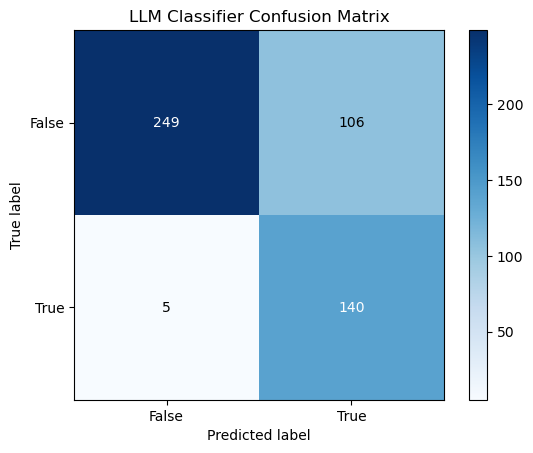

In [19]:
# Plot the confusion matrix using sckikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df['Actual Label'], 
                                    df['Predicted Label'], 
                                    title='LLM Classifier Confusion Matrix', 
                                    normalize=False)

<Axes: title={'center': 'LLM Classifier Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

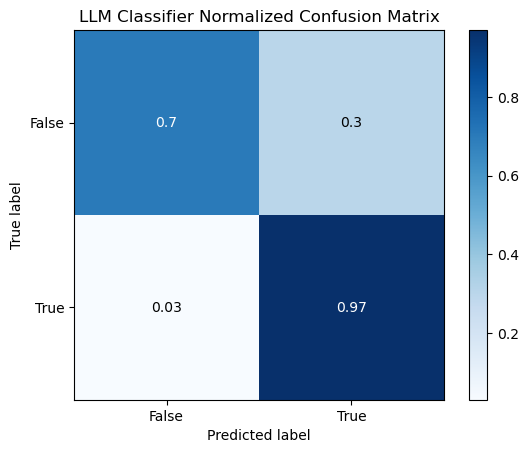

In [20]:
skplt.metrics.plot_confusion_matrix(df['Actual Label'], 
                                    df['Predicted Label'], 
                                    title='LLM Classifier Normalized Confusion Matrix', 
                                    normalize=True)

This matches my impressions during early testing of the LLM approach - despite my prompt engineering and few shot examples, the classifier was still overzealous in stating that things were bugfixes.

Because we had a significant portion of our rows assumed to be bugfix shift to non-bugfix, let's visualize the distribution of our two classes.

In [21]:
# Renaming colummns now will make visualziations easier later (though labels also work)
df.rename(columns={'Actual Label': 'Is Bug Fix', 'AuthorDateUtc': 'Date', 'Source': 'Repository'}, inplace=True)

In [22]:
px.histogram(df, 
             x='Is Bug Fix', 
             color='Is Bug Fix',
             title='Bug Fixes vs Non-Bug Fixes')

Yikes. That's a class mismatch for sure, but it might be within tolerances. Let's get a ratio

In [23]:
# Get a ratio of bug fixes to non-bug fixes
df['Is Bug Fix'].value_counts(normalize=True)

Is Bug Fix
False    0.71
True     0.29
Name: proportion, dtype: float64

Just shy of 30%. That's pretty close to my maximum allowable comfort level for binary classification. I'm inclined to continue on with this dataset, with the mindset that I may need to pull in more examples that are actual bugfixes if model performance struggles with the minority class later.

Let's see if there are any trends at the source level.

In [24]:
# Show bug fix ratio per source
px.histogram(df, 
             x='Is Bug Fix', 
             color='Is Bug Fix', 
             title='Bug Fix Distribution by Repository',
             facet_col='Repository')

Looks like the trend is somewhat universal, but the false positive rate was lower for GitStractor, but much higher for Wherewolf and Emergence. Interesting since I wrote all 3 of those repositories as the only contributor.

### Numerical Value Analysis
Let's start visualizing our major numerical distributions. These largely relate to lines of code and files added, deleted, and modified.

#### Net Lines of Code

In [25]:
px.box(df, 
       x='Net Lines',
       hover_data=common_hover_info, 
       labels=common_labels,
       title='Net Lines of Code Distribution')

In [26]:
px.box(df, 
       x='Net Lines',
       y='Is Bug Fix',
       color='Is Bug Fix',
       labels=common_labels,
       hover_data=common_hover_info, 
       title='Net Lines per Repository by Bugfix / Non-Bugfix')

In [27]:
px.box(df, 
       x='Net Lines', 
       y='Repository', 
       color='Repository',
       labels=common_labels,
       hover_data=common_hover_info, 
       title='Net Lines of Code per Repository')

As we can see, there are outliers here on a somewhat regular basis that distract from the overall norms. We'll need to handle these values by normalizing data, clipping values at the training pipeline level. Removing outliers entirely is not warranted here - particularly as we'll see later with this being a low correlation feature for our target variable.

### Lines Added / Deleted / Modified

In [28]:
px.histogram(df, x='Added Lines', marginal='box', color='Is Bug Fix', 
             labels=common_labels, hover_data=common_hover_info, title='Added Lines Distribution by Class')

In [29]:
px.histogram(df, x='Deleted Lines', marginal='box', color='Is Bug Fix', 
             labels=common_labels, hover_data=common_hover_info, title='Deleted Lines Distribution by Class')

In [30]:
px.scatter(df, x='Added Lines', y='Deleted Lines', color='Is Bug Fix', 
           labels=common_labels, hover_data=common_hover_info, title='Line +/- Distribution')

It looks like maybe bugfix commits seem to have more extreme values, but it's hard to tell. Let's add in another dimension

In [31]:
px.scatter_3d(df, x='Added Lines', y='Deleted Lines', z='Net Lines', color='Is Bug Fix', 
              labels=common_labels, hover_data=common_hover_info, title='Line +/- Distribution', width=1200, height=800)

Definitely clear relationships between added / deleted / net, but less clear on IsBugFix. Let's try using that as the Z dimension

In [32]:
px.scatter_3d(df, x='Added Lines', y='Deleted Lines', z='Is Bug Fix', color='Net Lines', 
              labels=common_labels, hover_data=common_hover_info, title='Line +/- Distribution', width=1200, height=800)

We do see different grouping patterns for the two groups, and one extreme outlier for the bugfix category. Again, our ML pipeline will handle clipping / normalizing these extreme values.

In [33]:
px.scatter_3d(df, x='Added Lines', y='Deleted Lines', z='Total Lines', color='Is Bug Fix', 
              labels=common_labels, hover_data=common_hover_info, title='Line +/- Distribution', width=1200, height=800)

In [34]:
show_corr(df[['Is Bug Fix', 'Added Lines', 'Deleted Lines', 'Net Lines', 'Total Lines']])

AttributeError: 'DataFrame' object has no attribute 'map'

Not much there aside from a faint faint negative correlation on net lines, but it's possible removing outliers improves it.

### Files Added / Deleted / Modified

In [35]:
px.histogram(df, x='Added Files', marginal='box', labels=common_labels, 
             hover_data=common_hover_info, title='Added Files Distribution', nbins=df['Added Files'].max() + 1)

That's a very zero-centric distribution when 1 added file is considered a high outlier. Let's see how relevant it is for bugfixes.

In [36]:
px.violin(df, 
       x='Added Files', 
       y='Is Bug Fix', 
       color='Is Bug Fix',
       labels=common_labels,
       hover_data=common_hover_info, 
       title='Added Files by BugFix Status')

This makes sense. Most of the time fixes work with existing files, while non-bugfixes are much more likely to add net-new code files.

In [37]:
# Get the Pearson correlation of IsBugFix and Added Files (this looks better as a DataFrame than a correlation matrix with only one valid cell)
df[['Is Bug Fix', 'Added Files']].corr()

,Is Bug Fix,Added Files
Is Bug Fix,1.000000,-0.079214
Added Files,-0.079214,1.000000


I guess we do have a very slight negative correlation, but it's much closer to 0 than actual negative. Let's see what happens if we cap added files to 10.

In [38]:
# Create a copy of the DataFrame, but with added files clipped to 5 max
df_clipped = df.copy()
df_clipped['Added Files'] = df_clipped['Added Files'].clip(upper=5)

# Get the Pearson correlation of IsBugFix and Added Files
df_clipped[['Is Bug Fix', 'Added Files']].corr()

,Is Bug Fix,Added Files
Is Bug Fix,1.000000,-0.085404
Added Files,-0.085404,1.000000


This makes the correlation more evident, but doesn't make a collosal difference. Let's try feature engineering a boolean column on the original DataFrame

In [39]:
df['Has Added Files'] = df['Added Files'] > 0

We'll see its correlation later. Let's move on to Deleted Files.

In [40]:
px.histogram(df, x='Deleted Files', color='Is Bug Fix', labels=common_labels, 
             title='Deleted Files Distribution by BugFix Status', 
             nbins=df['Deleted Files'].max() + 1, marginal='violin')

Looks like commits with deleted files tend to be non-bugfix commits more than they aren't, but we're a zero-centric distribution. Let's add a boolean column and get some correlations

In [41]:
df['Has Deleted Files'] = df['Deleted Files'] > 0

Finally, let's take a quick look at modified files. It should be very similar to added and deleted.

In [42]:
px.box(df, x='Modified Files', color='Is Bug Fix', y='Is Bug Fix', title='Modified Files Distribution by BugFix Status',)

Again, we have a lot of outliers and we'll need to clamp / normalize in the ML pipeline. Removing the outliers now could improve our correlation scores, but it would also limit our options later when training ML models.

In [43]:
show_corr(df[['Is Bug Fix', 'Total Files', 'Modified Files', 'Added Files', 'Deleted Files', 'Has Deleted Files', 'Has Added Files']])

AttributeError: 'DataFrame' object has no attribute 'map'

So, we have some faint correlations, especially with Has Added Files. These are all minor factors, but possibly relevant for a final model.

However, Deleted Files may not be important for a model at all.

### Work Items

We record a count of work items from issue management systems mentioned in the commit message (identified via a regular expression looking for common patterns). Let's see what trends we have there.

In [44]:
px.box(df, 
       x='Work Items',
       title='Number of Work Items Mentioned in Commit Messages', 
       hover_data=common_hover_info, 
       labels=common_labels).update_xaxes(tickvals=np.arange(0, df['Work Items'].max() + 1, 1))

In [ ]:
px.violin(df, 
       x='Work Items',
       color='Is Bug Fix',
       y='Is Bug Fix',
       title='Number of Work Items Mentioned in Commit Messages by BugFix Status', 
       hover_data=common_hover_info, 
       labels=common_labels).update_xaxes(tickvals=np.arange(0, df['Work Items'].max() + 1, 1))

: 

In [ ]:
df[['Is Bug Fix', 'Work Items']].corr()

: 

I would assume most bugfixes have at least one issue associated with them, but many features do as well. As a result, this is a near wash, but may be a minor helpful column.

### Date, Day of Week, and Time of Day Analysis

Relying on any sort of date / time data is risky for something intended to be used on any English-based git repository throughout the world, but let's see what the data tells us.

In [ ]:
px.histogram(df, 
             x='Date', 
             color='Repository', 
             labels=common_labels, 
             title='Commits per Repository over Time')

: 

In [ ]:
px.histogram(df, 
             x='Date', 
             color='Is Bug Fix', 
             labels=common_labels, 
             title='Commits by Bugfix Status over Time')

: 

In [ ]:
# Engineer day of week, month, quarter, and year from the AuthorDateUtc
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year
df['Hour'] = df['Date'].dt.hour
df['TimeOfDay'] = pd.cut(df['Hour'], bins=[0,6,12,18,24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

df['DayOfWeek'].value_counts()

: 

In [ ]:
# Order the days of the week in sequential order
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)
px.histogram(df.sort_values('DayOfWeek'),
             x='DayOfWeek', 
             color='Is Bug Fix', 
             labels=common_labels, 
             title='BugFix Commits by Day of Week')

: 

Clearly we have some lowered weekend activity. Also, there's an joke that not much work happens Friday afternoons in many development environments. This may actually be represented slightly in this chart.

In [ ]:
px.histogram(df.sort_values('DayOfWeek'),
             x='DayOfWeek', 
             color='Repository', 
             labels=common_labels, 
             barmode='group',
             title='Commits by Day of Week and Repository')

: 

In [ ]:
df['Is Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])

px.histogram(df, x='Is Weekend', color='Repository', title='Commits by Weekend / Weekday and Repository')

: 

It's faint due to scale, but you can see that the fun side projects of emergence, wherewolf, and gitstractor all have higher commit volumes around the weekend. This makes sense since I am the author and my focus is on other areas during the work week. On the other hand, the mainstay repositories of ML.NET and .NET Interactive get more proportional commits throughout the week through their authors day jobs. 

In [ ]:
px.histogram(df, x='Is Bug Fix', color='Is Weekend', title='Bugfix Commits by Weekend / Weekday')

: 

In [ ]:
px.histogram(df.sort_values('Quarter'), x='Is Bug Fix', color='Quarter', title='Bugfix Commits by Quarter',
             color_discrete_sequence=px.colors.sequential.Agsunset_r, barmode='group')

: 

In [ ]:
# Change month to be ordinal categorical
df["Month"] = pd.Categorical(df["Month"], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

px.histogram(df.sort_values('Month'), 
             x='Month', 
             color='Is Bug Fix', 
             title='Bugfix Commits by Month')

: 

In [ ]:
px.histogram(df.sort_values('Month'), 
             x='Month', 
             color='Repository', 
             title='Commits by Month by Repository')

: 

In [ ]:
df['TimeOfDay'] = pd.Categorical(df['TimeOfDay'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

px.histogram(df.sort_values('TimeOfDay'), 
             x='TimeOfDay', 
             color='Repository', 
             title='Commits by Time of Day by Repository')

: 

In [ ]:
px.histogram(df.sort_values('TimeOfDay'), 
             x='TimeOfDay', 
             color='Is Bug Fix', 
             title='Commits by Time of Day by BugFix Status')

: 

In [ ]:
px.histogram(df.sort_values('Hour'),
             x='Hour', 
             color='Is Bug Fix', 
             labels=common_labels, 
             title='BugFix Commits by Hour')

: 

In [ ]:
px.histogram(df.sort_values('Hour'),
             x='Hour', 
             color='Repository', 
             labels=common_labels, 
             title='Commits by Hour by Repository')

: 

This chart is interesting because it shows .NET Interactive having a wider range of horus committed on than ML .NET, even though ML .NET is another larger repository.

It's also interesting to see how my commits typically come in afternoons on the weekends and in the evenings and early mornings.

I happen to know that the .NET Interactive team revolves heavily around a man in Redmond and another man in the UK, so it's likely we're seeing time zone offsets in action here. Let's confirm that by looking at the commit patterns of the top authors for the repository.

In [ ]:
px.histogram(df[df['Repository'].eq('dotnetinteractive')].sort_values('Hour'),
             x='Hour', 
             labels=common_labels, 
             title='Commits by Hour for .NET Interactive Repository')

: 

In [ ]:
df_dotnetinteractive = df[df['Repository'].eq('dotnetinteractive')]

# Get a list of the top 5 authors by number of commits
top_authors = df_dotnetinteractive['AuthorId'].value_counts().head(5)
top_authors

: 

*Note: AuthorId is a sequential integer id within a repository and not a unique identifier across repositories. In other words, AuthorId 4 for ML.NET is very unlikely to be AuthorId 4 for .NET Interactive.*

In [ ]:

df_dotnetinteractive = df_dotnetinteractive[df_dotnetinteractive['AuthorId'].isin(top_authors.index)]
hist = px.histogram(df_dotnetinteractive,
             x='Hour', 
             color='AuthorId',
             facet_col='AuthorId',
             color_discrete_sequence=px.colors.qualitative.Vivid,
             labels=common_labels, 
             title='Commits by Hour for .NET Interactive Repository')

# Facet the data by authorId
hist.update_layout(barmode='stack', title='Commits by Hour for .NET Interactive Repository by Top Authors')

: 

This plot confirms that different committers work in different timezones, meaning that including time of day, day of week, hour, or weekend would potentially bias the model against different regions of the world. While it's theoretically possible to adjust time of day to author-local values, this is only possible if we have a sufficient number of commits from the author, which we will not have in the real world. As a result, time and date information should not be used in any model training for fear of biasing the model against different geographical regions.

### Correlation Analysis

In [ ]:
show_merged_corr(df)


: 

This shows that the most significant predictors for bugfix commits in the current datasaet are the author, the work items, whether or not the commit was a merge commit, and then which repository the commit occurred on.

I do not want to include author information or source repository information in the trained model in order to create a model that can be flexible and avoid bias. That means that I effectively have only very weak predictors.

Clearly I need more context, and that context has to come from the commit message.

## Text Analysis

In [ ]:
# Feature engineer a column with the number of characters in the message
df['Message Length'] = df['Message'].str.len()

px.histogram(df, x='Message Length', color='Is Bug Fix', 
             title='Message Length Distribution by BugFix Status', marginal='box', labels=common_labels)

: 

In [ ]:
# Also add in a word count column based on the number of words separated by spaces
df['Word Count'] = df['Message'].str.split().str.len()

px.histogram(df, x='Word Count', color='Is Bug Fix', title='Word Count Distribution by BugFix Status', 
             marginal='box', labels=common_labels)

: 

In [ ]:
show_corr(df[['Is Bug Fix', 'Message Length', 'Word Count']])

: 

Interesting. Before I sampled down to 500 rows, the message length and word count were slightly larger predictors for Is Bug Fix. This may be due to fewer merge commits making it into the sampled data. Those tend to be longer pieces of text.

In [ ]:
df[df['IsMerge'] == True][['Message', 'Message Length', 'Word Count', 'Is Bug Fix']].head()

: 

In [ ]:
# Show proportion of IsMerge to non-IsMerge
df['IsMerge'].value_counts(normalize=True)

: 

It's possible this could be a problem for model accuracy later on. For now, I'll keep going, but I may need to augment my training data with more examples of merge commits.

For now, let's on to other ways of featurizing text.

In [ ]:
# Combine all the messages into a single string and split into words
# The ENDOFCOMMIT sentinel value will help detect overlaps on bigrams and trigrams between commit messages
all_messages = ' ENDOFCOMMIT '.join(df['Message'].str.lower())
words = all_messages.split()
len(words)

: 

In [ ]:
# Remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]
len(words)

: 

In [ ]:
# Remove punctuation
import string

words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]
len(words)

: 

In [ ]:
# Remove empty strings
words = [word for word in words if word]
len(words)

: 

In [ ]:
# Stem common word endings
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
words = [stemmer.stem(word) for word in words]
len(words)

: 

In [ ]:
# Identify common unigrams
from collections import Counter
# Find all words where words are not ENDOFCOMMIT
unigram_words = [word for word in words if word != 'endofcommit']
word_counts = Counter(unigram_words)
word_counts.most_common(10)

: 

In [ ]:
# Chart the most common unigrams
px.bar(pd.DataFrame(word_counts.most_common(25), columns=['Word', 'Count']), x='Word', y='Count', title='Top 10 Unigrams', color='Count')

: 

This includes multiple mentions of dotnet arcade which is a common dependency of .NET Interactive (Polyglot Notebooks). This is a sign that this dataset has some inherent bias towards the patterns in its repositories and would benefit from a greater diversity of sources.

However, the final classifier the project produces can be used to augment this with additional labelled data.

In [ ]:
# Add in common unigrams to a copy of our dataframe as one-hot encoded columns
df_unigrams = df.copy()

# Apply our transformations to the Message column
df_unigrams['Message'] = df_unigrams['Message'].str.lower()
df_unigrams['Message'] = df_unigrams['Message'].str.split()
df_unigrams['Message'] = df_unigrams['Message'].apply(lambda x: [word for word in x if word not in stop_words])
df_unigrams['Message'] = df_unigrams['Message'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df_unigrams['Message'] = df_unigrams['Message'].apply(lambda x: [word for word in x if word])
df_unigrams['Message'] = df_unigrams['Message'].apply(lambda x: [stemmer.stem(word) for word in x])

# Create a one-hot encoded column for each unigram
for unigram, _ in word_counts.most_common(25):
    df_unigrams[unigram] = df_unigrams['Message'].apply(lambda x: unigram in x)

# Get only the word columns and the IsBugFix column and use them to build a correlation matrix
df_corr = df_unigrams[['Is Bug Fix'] + [unigram for unigram, _ in word_counts.most_common(25)]]
show_corr(df_corr)

: 

Now we're getting somewhere. We have a few stronger correlations, primarily fix, error, and updat. Bigrams will probably help via added context.

### Bigrams

In [ ]:
# Identify common n-grams
from nltk.util import ngrams
from collections import Counter

bigrams = ngrams(words, 2)
bigram_counts = Counter(bigrams)

# Sometimes we erroneously get a bigram from the last word in a message and the first word in the next message. 
# We protect against that with the endofcommit sentinel string so let's remove those from bigram_counts
bigram_counts = {bigram: count for bigram, count in bigram_counts.items() if 'endofcommit' not in bigram}

# Create a bigram DataFrame using keys and values from bigram_counts
df_bigram_freq = pd.DataFrame(list(bigram_counts.items()), columns=['Bigram', 'Count']).sort_values('Count', ascending=False)
df_bigram_freq['Bigram'] = df_bigram_freq['Bigram'].apply(lambda x: ' '.join(x))
df_bigram_freq.head()

: 

Again we see a few repo-specific things like the dotnet arcade URL and the term "magic command" which are both native to .NET Interactive. Another sign that we need a larger / broader training dataset for a universally useful classifier, but I do think what this produces will still have some value.

In [ ]:
# Chart the most common bigrams
px.bar(df_bigram_freq.head(25), x='Bigram', y='Count', title='Top Bigrams', color='Count')

: 

In [ ]:
# Get a copy of the main DataFrame
df_bigrams = df.copy()

# Apply our transformations to the Message column
df_bigrams['Tokens'] = df_bigrams['Message'].str.lower()
df_bigrams['Tokens'] = df_bigrams['Tokens'].str.split()
df_bigrams['Tokens'] = df_bigrams['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df_bigrams['Tokens'] = df_bigrams['Tokens'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df_bigrams['Tokens'] = df_bigrams['Tokens'].apply(lambda x: [word for word in x if word])
df_bigrams['Tokens'] = df_bigrams['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

df_bigrams.head()

: 

In [ ]:
# one-hot encode columns if the bigram is in the tokens
for bigram, _ in df_bigram_freq.itertuples(index=False):
    df_bigrams[bigram] = df_bigrams['Tokens'].apply(lambda x: bigram in [' '.join(x) for x in ngrams(x, 2)])

# Get only the bigram columns and the IsBugFix column and use them to build a correlation matrix
df_corr = df_bigrams[['Is Bug Fix'] + list(df_bigrams.columns[-25:])]

show_corr(df_corr)

: 

These results are much weaker, and we do see the name of Diego Columbo referenced in one token. Diego is a frequent contributor to .NET Interactive and he often names his branches after his name, so merge commits will include this since they include the branch name by default.

This means that there's an aspect of this data that will include some degree of PII and that will need to be something to consider.

### Trigrams

In [ ]:
trigrams = ngrams(words, 3)
trigram_counts = Counter(trigrams)

# Sometimes we erroneously get a bigram from the last word in a message and the first word in the next message. 
# We protect against that with the endofcommit sentinel string so let's remove those from bigram_counts
trigram_counts = {trigram: count for trigram, count in trigram_counts.items() if 'endofcommit' not in trigram}

# Create a bigram DataFrame using keys and values from bigram_counts
df_trigram_freq = pd.DataFrame(list(trigram_counts.items()), columns=['Trigram', 'Count']).sort_values('Count', ascending=False)
df_trigram_freq['Trigram'] = df_trigram_freq['Trigram'].apply(lambda x: ' '.join(x))
df_trigram_freq.head()

: 

In [ ]:
# Chart the most common bigrams
px.bar(df_trigram_freq.head(25), x='Trigram', y='Count', title='Top Trigrams', color='Count')

: 

In [ ]:
# Get a copy of the main DataFrame
df_trigrams = df.copy()

# Apply our transformations to the Message column
df_trigrams['Tokens'] = df_trigrams['Message'].str.lower()
df_trigrams['Tokens'] = df_trigrams['Tokens'].str.split()
df_trigrams['Tokens'] = df_trigrams['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df_trigrams['Tokens'] = df_trigrams['Tokens'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df_trigrams['Tokens'] = df_trigrams['Tokens'].apply(lambda x: [word for word in x if word])
df_trigrams['Tokens'] = df_trigrams['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

df_trigrams.head()

: 

In [ ]:
# one-hot encode columns if the trigram is in the tokens
for trigram, _ in df_trigram_freq.itertuples(index=False):
    df_trigrams[trigram] = df_trigrams['Tokens'].apply(lambda x: trigram in [' '.join(x) for x in ngrams(x, 3)])

# Get only the bigram columns and the IsBugFix column and use them to build a correlation matrix
df_corr = df_trigrams[['Is Bug Fix'] + list(df_trigrams.columns[-25:])]

show_corr(df_corr)

: 

That's pretty similar to the other example. There definitely isn't one strong predictor in this dataset, so we'll have to see how a model works with the best sets of minor predictors.

Overall, there's a lot of nuance to whether something is a bug or feature and that nuance is mostly conveyed through the commit message. However, there are a few other pockets of minor correlations for commits including whether or not files were added or deleted, the net lines of code, and others.

This definitely isn't a problem that can be handled with a simple naive approach, as words can mean one thing in one context and an entirely other thing in another context.

However, a performant classifier may still be possible without requiring advanced techniques like deep learning or foundation models, because there are a significant number of weak predictors for Is Bug Fix in this dataset.